Test Script for testing loading of the data

In [185]:
#Loading necessary libraries
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from PIL import Image
import numpy as np
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [6]:
#Loading Image Names for Stop and Non-Stop Images
stop_image_dir = "./Data/stop/"
not_stop_image_dir = "./Data/not_stop/"
stop_image_list =  os.listdir(stop_image_dir)
not_stop_image_list =  os.listdir(not_stop_image_dir)

In [68]:
#Find distribution of widths and heights
n_images = len(stop_image_list) + len(not_stop_image_list)
width_distr = np.zeros(n_images)
heigth_distr = np.zeros(n_images)

#Iterate Over Images
for i in range(len(stop_image_list)):
    stop_image_name = stop_image_list[i]
    temp_image = Image.open(stop_image_dir + stop_image_name)
    width_distr[i] = temp_image.width
    heigth_distr[i] = temp_image.height

for i in range(len(not_stop_image_list)):
    not_stop_image_name = not_stop_image_list[i]
    temp_image = Image.open(not_stop_image_dir + not_stop_image_name)
    width_distr[i+len(stop_image_list)] = temp_image.width
    heigth_distr[i+len(stop_image_list)] = temp_image.height

#Calculating means as target widths and heights
reshape_width = np.round_(np.mean(width_distr)).astype(int)
reshape_heigth = np.round_(np.mean(heigth_distr)).astype(int)


In [152]:
#Creating Custom DataSet
class stopNotStopData(Dataset):
    def __init__(self, stop_dir, not_stop_dir, transform=None, targetTransform=None):
        self.stop_dir = stop_dir
        self.not_stop_dir = not_stop_dir

        #Finding Number of Stop and Non-Stop Images
        self.stop_image_list =  os.listdir(stop_image_dir)
        self.not_stop_image_list =  os.listdir(not_stop_image_dir)
        self.n_stop_images = len(self.stop_image_list)
        self.n_not_stop_images = len(self.not_stop_image_list)
        self.n_images = self.n_not_stop_images + self.n_stop_images

        #Creating initial labels for images
        self.labels = np.zeros(self.n_images)

        self.transform = transform
        self.targetTransform = targetTransform

    def __len__(self):
        return self.n_images

    def __getitem__(self, idx):
        #First find the corresponding image
        if idx+1<=self.n_stop_images:
            image_name = self.stop_image_list[idx]
            image_path = os.path.join(self.stop_dir, image_name)
            #Image is a stop image first load it
            #image = Image.open(self.stop_dir+str(int(idx+1))+".JPG")
            image = Image.open(image_path)
            #image = np.asarray(image).astype(np.uint8)
            label = 0 # 0 is for stop image and 1 is for non-stop image
            self.labels[i] = 0 #Set it also in labels array
            if self.transform:
                image = self.transform(image)
            if self.targetTransform:
                label = self.targetTransform(label) 
        else:
            idx = idx - self.n_stop_images
            image_name = self.not_stop_image_list[idx]
            image_path = os.path.join(self.not_stop_dir, image_name)
            #image = read_image(self.not_stop_dir+str(int(idx+1))+".JPG")
            #image = Image.open(self.not_stop_dir+str(int(idx+1))+".JPG")
            image = Image.open(image_path)
            #image = np.asarray(image).astype(np.uint8)
            label = 1 # 0 is for stop image and 1 is for non-stop image
            self.labels[i] = 1 #Set it also in labels array
            if self.transform:
                image = self.transform(image)
            if self.targetTransform:
                label = self.targetTransform(label)

        return image, label



In [176]:
#Test of Splitting DataSet into train, validation and test
#Define Transformation on Image
image_transform = transforms.Compose([transforms.Resize(size=(reshape_width, reshape_heigth)), transforms.ToTensor()])
#Create DataSet object
full_data_set = stopNotStopData(stop_dir=stop_image_dir, not_stop_dir=not_stop_image_dir, transform=image_transform, targetTransform=None)

#First Find Number of Elements of each dataset
num_elements = np.round_([len(full_data_set)*0.8, len(full_data_set)*0.1, len(full_data_set)*0.1]).astype(int)
num_elements[0] = num_elements[0] - (np.sum(num_elements)-len(full_data_set))
#Split dataset into three parts
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(full_data_set, num_elements, generator=torch.Generator().manual_seed(75))


197
[157  20  20]


In [189]:
#Test of the training part for basic structure
class tevfik_nn(nn.Module):
    #Constructor
    def __init__(self):
        super(tevfik_nn, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1300*946, 1300*5),
            nn.ReLU(),
            nn.Linear(1300*5, 1300),
            nn.ReLU(),
            nn.Linear(1300, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = self.flatten(x)
        result = self.linear_relu_stack(x)
        return result

#Device Selection
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
print(device)

model = tevfik_nn().to(device)
x_test = torch.rand(1, 1900, 946, device=device)
y_yest = model(x_test)

cuda


RuntimeError: [enforce fail at C:\cb\pytorch_1000000000000\work\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 95924400000 bytes.

In [177]:
#Test can it be transferrable to dataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32 ,shuffle=True)
valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=len(valid_dataset), shuffle=True)

train_features, train_labels = next(iter(train_dataloader))
print(len(train_labels))

32


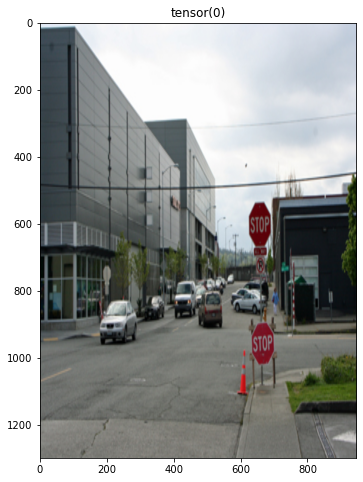

(1300, 946, 3)


In [186]:
import matplotlib.pyplot as plt
from random import randrange

idx = randrange(32)

#Load the Data
data = train_features[idx]
[rgb, n_y, n_x] = data.shape

image = np.zeros([n_y, n_x ,rgb])
for i in range(rgb):
    image[:,:,i] = data[i][:][:]

plt.figure(figsize=(8,8))
plt.imshow(image)
plt.title(str(train_labels[idx]))
plt.show()
print(image.shape)